# Figures 1 and 2
This notebook creates the following figures:

* Fig. 1: Automatic segmentation of putative glomeruli
* Fig. 2: The spectrum of MOL2.3/MOR18-2
* Supplementary Fig. S1: Exemplary odor responses.


In [1]:
import os 
import csv
import glob
import json
import StringIO
import scipy
import matplotlib
#import pylab
import numpy as np
from matplotlib import gridspec
from collections import defaultdict


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# get the regnmf package from https://github.com/Huitzilo/FUImaging
import regnmf.ImageAnalysisComponents as ia

In [4]:
# download the preprocessed data from XXX
basepath = os.path.realpath(os.path.join(os.path.pardir, 'glomcentric_data_preprocessed'))
datadict_path = os.path.join(basepath, 'DataDicts')
savepath = os.path.realpath(os.path.join('.', 'results'))
if not os.path.exists(savepath):
    os.mkdir(savepath)


In [5]:
#some global settings
fig_dim = (7.48,9.4) #dimensions of the figure
global_fs= 8 #font size 

layout = {   'axes.labelsize': 8,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'figure.dpi': 150   
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

In [6]:
stim_cut = (3,5) 

#translate CAS numbers to molecule names
cas2name = {l[0]:l[1] for l in csv.reader(open(os.path.join(datadict_path,'Name2MomCas.tab')),  delimiter='\t')}
cas2name['7440-37-1'] = 'Argon (Control)'

# ... and the reverse lookup
name2cas = dict([(n,c) for c,n in cas2name.items()])

### Helper functions

In [7]:
def no_ticks(ax):
    """
    remove ticks from axis.
    """
    ax.set_xticks([])
    ax.set_yticks([])
    
def no_spines(ax):
    """
    remove spines from axis.
    """
    for sploc in ['top', 'bottom', 'left', 'right']: 
        ax.spines[sploc].set_visible(False)
  
# timecourses plotter
rep_param = defaultdict(lambda: {'linewidth':1, 'ls':'--', 'color':'0.8'})
rep_param.update({0:{'linewidth':0.6, 'ls':'--' , 'color':'k','marker':'.', 'ms':2, 'dashes':(2,2)}, 
           1:{'linewidth':0.6, 'ls':'--', 'color':'0.4', 'marker':'.','ms':2, 'dashes':(2,2), 'mec':'0.4'}})

def timeplot(ax, data, mode):
    """
    Plot the time series of mode activations in the decomposed signal. 
    Assumes each odor is represented by five measurements.
    
    Parameters:
        ax - axis to plot into.
        data - TimeSeries object from a decomposed measurement file.
        mode - index of the NMF mode extracted in the decomposed measurement file.
        
    Plot parameters are defined in global variable rep_param.
    """
    xtime = np.arange(5)
    stimpos_dict = defaultdict(list)
    for lab_ind, lab in enumerate(data.label_stimuli):
        stimpos_dict[lab].append(lab_ind)
    for stim_num, stim in enumerate(stimpos_dict.keys()): #here I could sort the stimuli
        for stimrep, stimpos in enumerate(stimpos_dict[stim]):
            xpoints = xtime + stim_num*5
            # only 2 repitions
            if stimrep >1:
                break          
            
            if stim_num == 0: # plot with legend
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode], label='trial %d'%(stimrep+1), **rep_param[stimrep])
            else:
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode],**rep_param[stimrep])

    myxticks = np.hstack([xtime+i*5 for i in range(len(stimpos_dict))])
    yticks = [0,1,2]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.yaxis.set_tick_params(labelsize=7)
    #ax.set_xticks(myxticks, minor=True)
    ax.set_xticks(range(0, len(stimpos_dict)*5, 5))
    ax.set_xticklabels([])
    ax.set_xlim((0,len(stimpos_dict)*5))
    ax.yaxis.set_ticks_position('right')

def base_overlay(ax, bg, toplot, alpha_thres=0.3):
    """
    Overlay an 2d-array over a background image.
    
    Parameters:
    ax - the axis to plot in.
    bg - the background image (e.g. from imread)
    toplot - the 2D array to plot over bg
    alpha_thresh - toplot will be transparent (alpha=0) for values below this. 
    """
#    fig_temp = plt.figure()
#    ax_temp = fig_temp.add_subplot(111)
##    toplot_rgba = plt.cm.jet(toplot) #cmap_bases((toplot+1)/2.)
##    alpha =0.8*np.ones(toplot.shape)
##    alpha[np.abs(toplot)<alpha_thres]=0
##    toplot_rgba[:,:,3]=alpha
    ax.imshow(bg, interpolation='nearest', cmap=plt.cm.bone, vmin=-.1)
##    img = ax.imshow(toplot_rgba, interpolation='nearest')
    cmap = plt.cm.jet
    cmap.set_under(color=u'k', alpha=0.)
    img = ax.imshow(toplot, interpolation='nearest', vmin=alpha_thres, cmap=cmap)
    cbar = colorbar(ax=ax, mappable=img, extend='min', orientation='horizontal')
    cbar.set_ticks([alpha_thres, 1])
    cbar.set_label('pixel part.', fontsize=6, labelpad=-3)
    ax.set_axis_off()
    no_ticks(ax)
    
    
#    ax_temp.imshow(bg, interpolation='none', cmap=plt.cm.bone, vmin=-.1)#, extent=[-0.5,168-0.5,128-0.5,-0.5], vmin=-0.1)
#    ax_temp.hold(True)
#    ax_temp.imshow(toplot_rgba, interpolation='none')
#    ax_temp.set_axis_off()
#    no_ticks(ax_temp)
#    temppng = StringIO.StringIO()
#    fig_temp.savefig(temppng, format='png', bbox_inches='tight', pad_inches=0)
#    plt.close(fig_temp)
#    temppng.seek(0)
#    im = plt.imread(temppng)
#    ax.imshow(im, interpolation='nearest')
    no_ticks(ax)
    
def condense_list_dict(dic, reducefct=np.mean):
    ''' apply reducefct to every value of dictionary'''
    reduced_dict = {}
    for k, v in dic.items():
        reduced_dict[k] = reducefct(v)
    return reduced_dict

### Get the data

Load data file from animal 110224 and compute mean response during stimulus.

In [8]:
#particularly useful animals with many modes
# '110224' #two bulbs
# 110210, 110211, 110215, 110505, 110506, 120107, 120125

animals = {'110224':{}, #two bulbs
           '110210':{}, 
           '110211':{}, # 4 MOL23 occurences, axons visible, but filtering artifacts
           '110215':{},
           '110505':{},
           '110506':{},
           '120107':{},
           '120125':{}}

animals['110224'] = {'mol23_mode':4,
                     'other_mode':22,  #also have a look at 21, 50, 22
                     'zoom_region': {'x':(200,500,950,1250), 'y':(300,800)},
                     'mode_zoom_factor': 8.,
                     'cas2plot': ['Ethyl propionate',
                                  'Ethyl valerate',
                                  'Butyl valerate',
                                  'Argon (Control)']#u'105-37-3', u'105-54-4', u'5837-78-5', u'7440-37-1'] #u'141-78-6',
                     }

animals['110210'] = {'mol23_mode':23,
                     'other_mode':140,  # close ones are 106, 13, 140, 108, 178, 107, 106
                     'zoom_region': {'x':(200,950), 'y':(150,600)},
                     'mode_zoom_factor': 16.,
                     'cas2plot':['Ethyl acetate',
                                 'Propyl acetate',
                                 'Ethyl propionate',
                                 'Argon (Control)']}

animals['110211'] = {'mol23_mode':20, # but some axons seem to converge in mode 3
                     'other_mode':15,  # close ones are 44, 15, 183, 146 , strong inh in 44
                     'zoom_region': {'x':(200,950), 'y':(300,800)},
                     'mode_zoom_factor': 16.,
                     'cas2plot': ['Methyl propionate',
                                  'Ethyl propionate',
                                  'Ethyl valerate', # high response in neighboring mode
                                  'Argon (Control)']
                    }



animal = '110211'

# the index of the decomposition mode pertaining to MOL2.3
mol23_mode = animals[animal]['mol23_mode']
# another, neighboring mode for comparison
other_mode = animals[animal]['other_mode']
#the region to zoom in on for th MOL23 mode
zoom_region = animals[animal]['zoom_region']
# the mode has to be scaled by this factor to match the background image's size
mode_zoom_factor = animals[animal]['mode_zoom_factor']
# the top MOL23 ligands (plus argon) for this specimen will be plotted
cas2plot = [name2cas[name] for name in animals[animal]['cas2plot']]

#mol23_mode = 4
#other_mode = 57 #also have a look at 21, 50, 22


method =  'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_meas'
# meaning NNMF decomposition with 200 modes, 
# smoothness 2, 
# convex cone initialisation, 
# negTimelowSP - negative time course allowed (spatial mode still strictly positive), low sparseness
# sp* - sparseness factor (wildcard because the value is autmatically adjusted to use the value 
#         when correlation between modes drops below 0.5)
# ios_meas - prefix of original data file 



filt_data_file = os.path.join(basepath, 'MOBconverted', animal, 'ios_meas')
filt_data = ia.TimeSeries()
filt_data.load(filt_data_file)
filt_data = ia.TrialMean()(ia.CutOut(stim_cut)(filt_data))
filt_data.label_stimuli = [i.split('_')[0] for i in filt_data.label_stimuli]



Load the background image with the GFP signal (bg.png) and the green image showing an overview of the imaged area.

In [9]:
bg_file = os.path.join(basepath, 'MOBconverted', animal, 'bg.png')
green_file = os.path.join(basepath, 'MOBconverted', animal, 'green.png')

bg = plt.imread(bg_file)
green = plt.imread(green_file)

Load the decomposed data from the selected animal.

In [10]:
mf_filename = glob.glob(os.path.join(basepath, 'MOBdecomposed', animal, method+'.npy'))
assert len(mf_filename)==1
mf_filename = mf_filename[0].split('.')[0]

mf = ia.TimeSeries()
mf.load(mf_filename)
mf.label_stimuli = [i.split('_')[0] for i in mf.label_stimuli]


## Figure 1: Decomposition of dorsal olfactory bulb recordings into putative glomeruli. 

panel c:Methyl propionate is at index 51.
panel c:Ethyl propionate is at index 21.
panel c:Ethyl valerate is at index 27.
panel c:Argon (Control) is at index 29.
panel h: Methyl propionate is at 0
panel h: Ethyl propionate is at 1
panel h: Ethyl valerate is at 16
panel h: Argon (Control) is at 40
panel h: Top three MOL23 Ligands: ['Methyl propionate','Ethyl propionate','Propyl acetate']


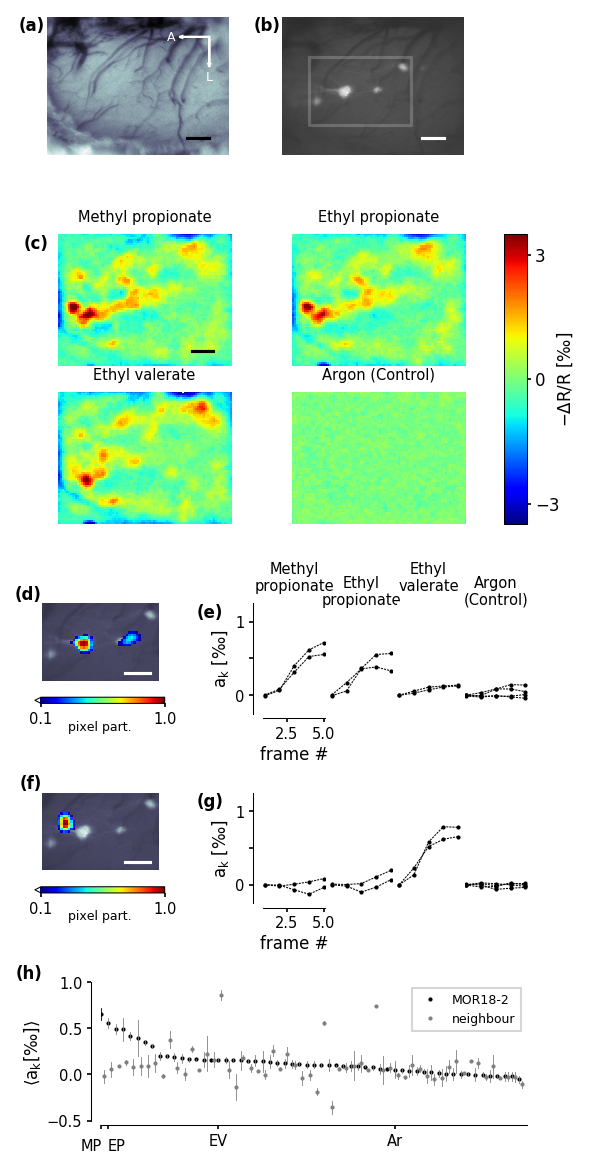

In [11]:
# Partition panel and make all axes

panel1 = plt.figure(figsize=(4., 8.))

# the gridspec for the whole figure
gs0 = gridspec.GridSpec(5,1, 
                        hspace=0.5,
                        top=0.97, 
                        bottom=0.05,
                       left=0.08,
                       right=0.9,
                       height_ratios=[1.,2.1,.8,.8,1.])

# gridspec for a and b
gs_ab = gridspec.GridSpecFromSubplotSpec(1,3, 
                                         subplot_spec=gs0[0,0], 
                                         width_ratios=[0.475,0.475,0.05])
#axis for a 
a_ax = panel1.add_subplot(gs_ab[0,0])
#axis for b
b_ax = panel1.add_subplot(gs_ab[0,1])

#gridspec for c
gs_c = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[1,0], width_ratios=[0.475,0.475,0.05], wspace=0.1)
#axes for c
grid_locs = [(0,0),(0,1),(1,0),(1,1)]
c_axes = [panel1.add_subplot(gs_c[gind]) for gind in grid_locs] 
axbar = panel1.add_subplot(gs_c[:,2])

#gridspec for d and e
gs_de = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[2,0], wspace=0.5, width_ratios=[.33,.67])
#axis for d
d_ax = panel1.add_subplot(gs_de[0,0])

#gridspec for e
gs_e = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs_de[0,1], wspace=0.08, hspace=0.3)
e_axes = [panel1.add_subplot(gs_e[eind]) for eind in range(4)] 

#gridspec for f and g
gs_fg = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[3,0], wspace=0.5, width_ratios=[.33,.67])
#axis for f
f_ax = panel1.add_subplot(gs_fg[0,0])
#gridspec for g
gs_g = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs_fg[0,1], wspace=0.08, hspace=0.3)
g_axes = [panel1.add_subplot(gs_g[eind]) for eind in range(4)] 

#gridspec for h
gs_h = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[4,0], wspace=0.08, width_ratios=[0.1,0.9] )
h_ax = panel1.add_subplot(gs_h[1])
#h_ax = panel1.add_subplot(gs0[5,0])

# a)
# plot green image
im_h = a_ax.imshow(green, interpolation='none', cmap=plt.cm.bone)
no_ticks(a_ax)
no_spines(a_ax)
a_label = a_ax.text(-15,0,'(a)', ha='right', va='top', fontsize=global_fs, fontweight='bold')
ap_arrowcolor = [1.,1.,1.]
arr1 = a_ax.arrow(1200,150,-200,0, head_width=15., color=ap_arrowcolor)
arr2 = a_ax.arrow(1200,150,0,200, head_width=15., color=ap_arrowcolor)
arrlabA = a_ax.text(950,150, 'A', color=ap_arrowcolor, fontsize=6, ha='right', va='center')
arrlabA = a_ax.text(1200,400, 'L', color=ap_arrowcolor, fontsize=6, ha='center', va='top')

# Add scalebar
# long edge: 1.63 mm on 1344 px (for single bulb image, double that size for double hemisphere image)
pixel_size = 1.63/1344. *1000. #µm
len_200 = 200./pixel_size   # 200 µm

scale_bar = a_ax.plot((1200,1200-len_200),(900,900),'k')


# b)    
# plot gfp image
im_h = b_ax.imshow(bg, interpolation='nearest', cmap=plt.cm.binary_r, vmin=-0.1)
scale_bar = b_ax.plot((1200,1200-len_200),(900,900),'w')
no_spines(b_ax)
no_ticks(b_ax)
b_label = b_ax.text(-15,0,'(b)', ha='right', va='top', fontsize=global_fs, fontweight='bold')
# zoom window
y1,y2 = zoom_region['y']
zx = zoom_region['x']
if len(zx) == 4: #two zoom windows, for double bulb imaging
    x1, x2, x3, x4 = zx 
    b_pl1 = b_ax.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], color='white', alpha=0.2)
    b_pl2 = b_ax.plot([x3,x4,x4,x3,x3],[y1,y1,y2,y2,y1], color='white', alpha=0.2)
else:
    x1, x2 = zx
    b_pl1 = b_ax.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], color='white', alpha=0.2)
    
# c)
# plot odor maps


for cax, cas in zip(c_axes, cas2plot):
    ind = filt_data.label_stimuli.index(cas)
    toplot = filt_data.shaped2D()[ind] #only the first repetition 
    print("panel c:{} is at index {}.".format(cas2name[cas], ind))
    im_h = cax.imshow(toplot, interpolation='none', vmin=-3.5, vmax=3.5, cmap='jet')
    cax.set_title(cas2name[cas], size=7)
    no_ticks(cax)    
    no_spines(cax)
    
#scalebar
func_scale_fac = toplot.shape[0]/float(bg.shape[0])
sb_x = 1200 * func_scale_fac
sb_y = 900 * func_scale_fac
sb_len = len_200 * func_scale_fac
scale_bar = c_axes[0].plot((sb_x,sb_x-sb_len),(sb_y,sb_y),'k')

# add colorbar
cbar = panel1.colorbar(im_h, axbar)
cbar.set_ticks([-3,0,3])
cbar.set_label(r'$-\Delta R/R$'+ u' [\u2030]', size=global_fs, labelpad=-2)
axbar.yaxis.set_tick_params(labelsize=global_fs, pad=2)
c_label = c_axes[0].text(-5,0,'(c)', ha='right', va='top', fontsize=global_fs, fontweight='bold')


# d), e), f) and g)
# two neighboring modes and example responses
import scipy.ndimage

def plot_mode_and_responses(modeax, 
                            respaxes, 
                            zoomreg, 
                            bg, 
                            modeind, 
                            data, 
                            cas2plot, 
                            letters=('d','e'), 
                            titles=True):
    mode = mf.base.shaped2D()[mode_to_plot] 
    mode_bgsize = scipy.ndimage.zoom(mode, mode_zoom_factor, order=0)
    #zoom into MOL2.3 region and show mode 4 on GFP pic
    y1,y2 = zoomreg['y']
    zx = zoomreg['x']
    if len(zx) == 4: # double bulb
        x1, x2, x3, x4 =  zx
        zoom_bg_l = bg[y1:y2, x1:x2]
        zoom_bg_r = bg[y1:y2, x3:x4]
        bg_zoom = np.concatenate((zoom_bg_l, np.ones((y2-y1,10)), zoom_bg_r), axis=1)
        mode_zoom_l = mode_bgsize[y1:y2, x1:x2]
        mode_zoom_r = mode_bgsize[y1:y2, x3:x4]
        mode_zoom = np.concatenate((mode_zoom_l, np.zeros((y2-y1,10)), mode_zoom_r), axis=1)
    else:
        x1, x2 = zx
        bg_zoom = bg[y1:y2, x1:x2]
        mode_zoom = mode_bgsize[y1:y2, x1:x2]
    base_overlay(modeax, bg_zoom, mode_zoom, alpha_thres=0.1)
    # put scalebar 50 px inwards from lower right edge
    sb_y, sb_x = mode_zoom.shape 
    sb_x -= 50
    sb_y -= 50
    scale_bar = modeax.plot((sb_x,sb_x-len_200),(sb_y,sb_y),'w')

    no_spines(modeax)
    d_label = modeax.text(1.,-0.,'('+letters[0]+')', ha='right', va='bottom', size=global_fs, fontweight='bold' )

    # parameters for odor responses
    plot_param = {'color':'black', 'linewidth':0.5, 'marker':'.', 'ms':2, 'ls':'--', 'dashes':(2,1)}

    for cas, e_ax in zip(cas2plot, respaxes):
        indices = [i for i,cas_data in enumerate(mf.label_stimuli) if cas_data == cas]
        for ind in indices:
            e_ax.plot(range(1,6),mf.trial_shaped()[ind,:,mode_to_plot], **plot_param)
        if titles:
            title = e_ax.set_title(cas2name[cas].replace(' ','\n'), fontsize=7, zorder=100000)
            if cas2plot.index(cas) %2 == 1:
                title.set_position((0.5, 0.875))
        e_ax.set_ylim((-.5,2.5))
        e_ax.set_xlim((0.9, 5.1))
        if (cas == cas2plot[0]):
            e_ax.spines['right'].set_visible(False)
            e_ax.spines['top'].set_visible(False)
            e_ax.spines['left'].set_position(('outward', 5))
            e_ax.spines['bottom'].set_position(('outward', 2))
            e_ax.set_yticklabels(['','0','','1','','2',''])
            e_ax.xaxis.set_ticks_position('bottom')
            e_ax.yaxis.set_ticks_position('left')
            e_ax.set_xlabel('frame #', size=global_fs, labelpad=2)
            e_ax.set_ylabel('$a_k$' + u' [\u2030]', size=global_fs, labelpad=2)
            e_label = e_ax.text(-1.8,2.5,'('+letters[1]+')', ha='right', va='top', size=global_fs, fontweight='bold' )
        else:
            no_spines(e_ax)
            no_ticks(e_ax)
        
        
mode_to_plot = mol23_mode #this is the MOL 2.3 mode in this specimen
plot_mode_and_responses(d_ax, e_axes, zoom_region, bg, mode_to_plot, mf, cas2plot)

mode_to_plot = other_mode #22 #a mode adjacent to the MOL2.3 mode
plot_mode_and_responses(f_ax, g_axes, zoom_region, bg, mode_to_plot, mf, cas2plot, letters=('f','g'),titles=False)


# h)
# the spectrum of the two modes in this specimen
def extract_spectrum(data, mode, stimuli):
    resp_dict = {}
    for stim in stimuli:
        indices = [i for i,cas_data in enumerate(data.label_stimuli) if cas_data == stim]
        responses = data.trial_shaped()[indices,:,mode]
        mean_resps = np.mean(responses, axis=1)
        total_mean_resp = np.mean(mean_resps)
        resp_dict[stim] = {'indices':indices, 
                           'resp':responses, 
                           'mean_resps': mean_resps, 
                           'total_mean_resp':total_mean_resp}
    return resp_dict

stimuli = list(set(mf.label_stimuli))
mol23_resp_dict = extract_spectrum(mf, mol23_mode, stimuli)
mol23_series = np.array([mol23_resp_dict[stim]['total_mean_resp'] for stim in stimuli])
mol23_all = np.array([mol23_resp_dict[stim]['mean_resps'] for stim in stimuli])

#arrange by mol23 activity
seq = np.argsort(mol23_series)[::-1]

other_resp_dict = extract_spectrum(mf, other_mode, stimuli)
other_series = np.array([other_resp_dict[stim]['total_mean_resp'] for stim in stimuli])
other_all = np.array([other_resp_dict[stim]['mean_resps'] for stim in stimuli])

plot_params = {'marker':'.', 'ms':2, 'linestyle':'none'}
error_params = {'linewidth':0.4, 'color':'black'}

xaxis = np.arange(len(mol23_series))

h_ax.plot(xaxis, mol23_series[seq], mec='k', label="MOR18-2", **plot_params)
#h_ax.hold(True)
h_ax.plot(xaxis+0.4, other_series[seq], mec='grey', label="neighbour", **plot_params)
for i,s in enumerate(seq):
    y = mol23_all[s]
    h_ax.plot(numpy.ones_like(y)*i, y, **error_params)
    error_params['color'] = 'grey'
    y = other_all[s]
    h_ax.plot(numpy.ones_like(y)*i+0.4, y, **error_params)    
h_ax.set_ylabel(u'$\langle a_k {} \\rangle $ '.format(u'[\u2030]') , size=global_fs, labelpad=2)
h_ax.set_xlim((0,len(seq)))

# positions of  example odors
ticks = [list(seq).index(stimuli.index(c2p)) for c2p in cas2plot]
ticklabels = ['','','EV','Ar'] # MP and EP at index 1 will be added by hand
for c2p,tick in zip(cas2plot,ticks):
    print("panel h: {} is at {}".format(cas2name[c2p], tick))

h_ax.set_xticks(ticks)
h_ax.set_xticklabels(ticklabels)   
h_ax.text(0.15,-.7,'MP', fontsize=7, va='top', ha='right')
h_ax.text(0.85,-.7,'EP', fontsize=7,  va='top', ha='left')


h_ax.spines['top'].set_visible(False)
h_ax.spines['right'].set_visible(False)
h_ax.spines['left'].set_position(('outward',5))
h_ax.spines['bottom'].set_position(('outward',2))
h_ax.xaxis.set_ticks_position('bottom')
h_ax.yaxis.set_ticks_position('left')
h_ax.set_yticks([-.5,0.,.5,1.0])
h_ax.text(-8, 1., "(h)", ha='right', va='bottom', size=global_fs, fontweight='bold' )

ligands_hitlist = [cas2name[stimuli[i]] for i in seq] 
h_ax.legend(fontsize=6, 
            frameon=True, 
            fancybox=False, 
            loc='upper right', 
            bbox_to_anchor=(1.0,1.0))
print("panel h: Top three MOL23 Ligands: ['{}','{}','{}']".format(ligands_hitlist[0], ligands_hitlist[1],ligands_hitlist[2]))



In [12]:
#plt.tight_layout()
panel1.savefig(os.path.join(savepath, 'MOB_Figure1.png'), dpi=600)

In [13]:
ligands_hitlist[16]

'Ethyl valerate'

In [14]:
plt.close('all')

# Figure 2: MOR18-2 spectrum. 

Load the MOL 2.3 spectrum.

In [15]:
average_function = np.median
methodspec =  'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_measnormed'

mor182specIOS_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')
mor182specIOS = json.load(open(mor182specIOS_file))

#Select only pure odors. Hack! All mixtures contain either E or A 
pure_odors = [o for o in mor182specIOS[methodspec].keys() if (len(o.split('_'))<2) and ('E' not in o) and ('A' not in o) and  ('B' not in o) ] 
pure_odor_resp = [average_function(mor182specIOS[methodspec][o]) for o in pure_odors]
odors_sorted = [pure_odors[i] for i in np.argsort(pure_odor_resp)] 
spec = [average_function(mor182specIOS[methodspec][i]) for i in odors_sorted]

Test whether odor responses in MOL2.3 are significantly different from Argon responses.

In [16]:
test = scipy.stats.ttest_ind # scipy.stats.mannwhitneyu#

p_val_argon = numpy.ones(len(odors_sorted))
for ii,i in enumerate(odors_sorted):
    if len(mor182specIOS[methodspec][i]) > 1: # testing a 1-sample distribution would be an error
        p_val_argon[ii] = test(mor182specIOS[methodspec]['7440-37-1'], mor182specIOS[methodspec][i])[1]
p_val_argon[p_val_argon>0.05] = 1.

Plot the MOL23 spectrum.

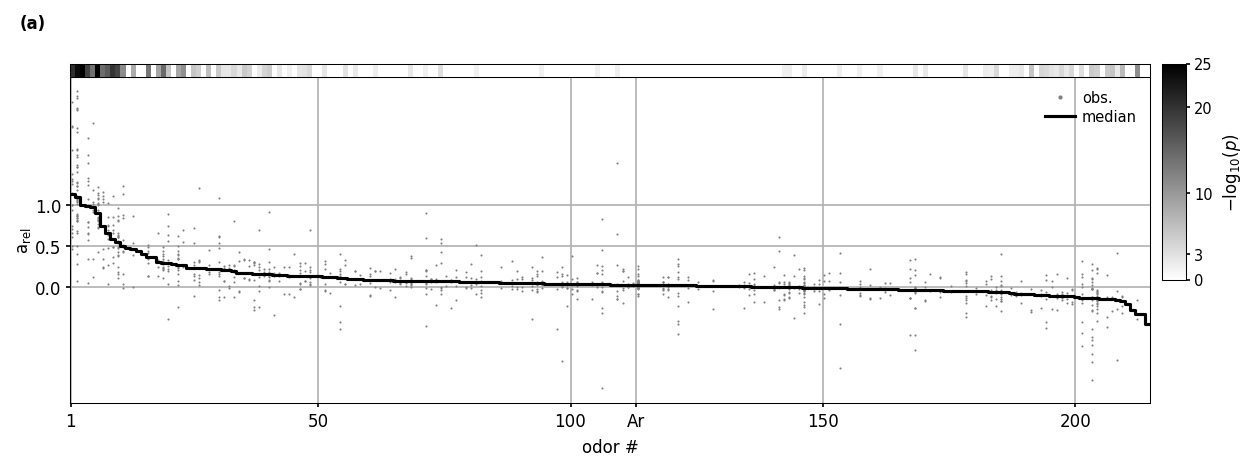

In [21]:
fig  = plt.figure(figsize=(8,3))

#gs = matplotlib.gridspec.GridSpec(1,2, top=0.95, bottom=0.05,width_ratios=[25,1], wspace=0)
#gsbar = matplotlib.gridspec.GridSpec(1,1, top=0.95, bottom=0.6, left=0.92, right=0.95)
#axbar = fig.add_axes(bottom=0.5, left=0.)

gs = matplotlib.gridspec.GridSpec(2,1, left=0.05, right=0.95, height_ratios=[1,25], hspace=0)
gsbar = matplotlib.gridspec.GridSpec(1,1, left=0.96, right=0.98, bottom=0.4)
axbar = fig.add_axes(bottom=0.5, left=0.)


num_odors = len(spec)


ax = fig.add_subplot(gs[1])
# individual measurements
for ix, mol in enumerate(odors_sorted):
    points = ax.plot(num_odors - ix, np.array(mor182specIOS[methodspec][mol]).reshape((1,-1)), '.', 
                     ms=2, mec='none', mfc='0.5')


#average activation
stairs = ax.step(np.arange(num_odors+1,0,-1)-0.5, [spec[0]]+spec, 'k', lw=1.5)

#decorate. num_odors=214
#ax.set_xticks([num_odors, num_odors-50, num_odors-100, odors_sorted.index('7440-37-1'), num_odors-150, num_odors-200])
ax.set_xticks(np.array([1,50,100,num_odors-odors_sorted.index('7440-37-1'), 150,200]) -0.3)
ax.set_xticklabels(['1','50','100','Ar','150','200'], size=8)
#ax.set_xticks([odors_sorted.index(i) for i in ['7440-37-1']], minor=True)
#ax.set_xticklabels(['Ar'], minor=True, size=8, rotation='45', ha='right')

ax.set_xlim((0.5, num_odors+0.5))
ax.set_yticks([0,0.5,1])
ax.yaxis.set_tick_params(labelsize=8)
ax.grid()
ax.set_ylabel('$a_{rel}$', size=8, labelpad=1)
ax.set_xlabel('odor #', size=8)
ax.legend((points[0], stairs[0]), ('obs.', 'median'), loc='upper right', frameon=False,
          fontsize=7, numpoints=1, handletextpad=0.5, labelspacing=0.3, markerscale=2)

ax = fig.add_subplot(gs[0])
im = ax.imshow(-np.log10(p_val_argon[::-1]).reshape((1,-1)), plt.cm.binary, interpolation='none', aspect='auto', vmax=25)
ax.set_xlim((-0.5, num_odors-0.5))
ax.set_xticks([])
ax.set_yticks([])
#ax.set_ylabel('p Argon', rotation='0', ha='right', size=8)

cbar = fig.add_subplot(gsbar[0])
cbar = fig.colorbar(im, cax=cbar)
cbar.set_label('$-{log}_{10}(\mathit{p})$')
cbar.set_ticks([0,3,10,20,25])

fig.text(0.03, 0.95, '(a)', ha='right', va='bottom', fontsize=8, fontweight='bold')

plt.show()


In [22]:
fig.savefig(os.path.join(savepath, 'FigMOR18-2spec.png'), dpi=600, bbox_inches='tight')

In [23]:
close('all')

[]

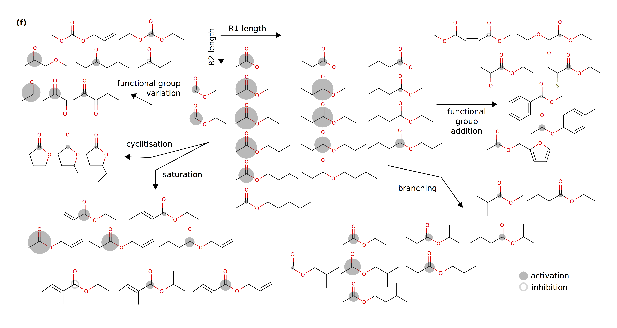

In [20]:
#######
# DELETE FROM SUBMISSION
###

# This cell was originally embedding the structure drawings into the Figure.
f = figure() 
mrr = plt.imread('MRR182pic.png')
gs = matplotlib.gridspec.GridSpec(1,1, top=0.51, bottom=0.02, left=0.05, right=0.98)
ax = f.add_subplot(gs[0])
ax.imshow(mrr)
for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])


66


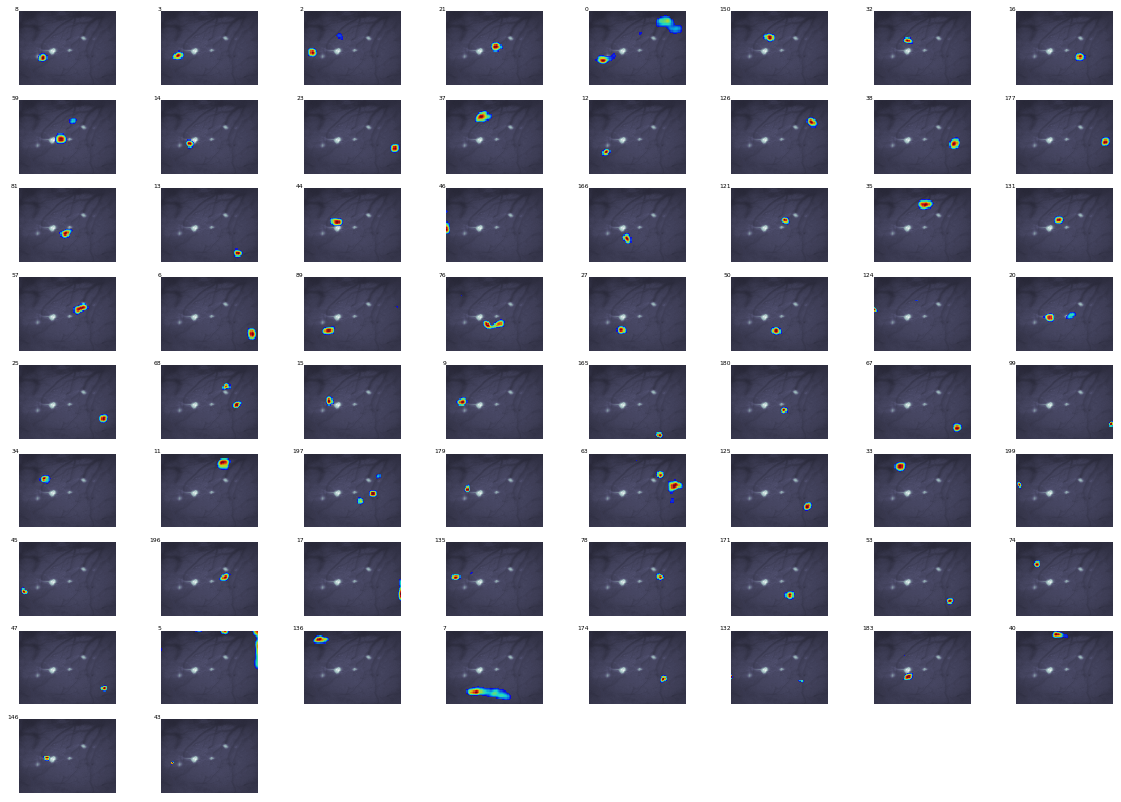

In [20]:
# This figure just shows all relevant modes, not part of the paper
t2t = ia.CalcStimulusDrive()(mf)
t2t_corr = t2t._series.flatten()
t2t_sortind = np.argsort(t2t_corr)
modes_above_06 =  t2t_sortind[np.where(t2t_corr[t2t_sortind] < 0.4)]
print len(modes_above_06)
gs = plt.GridSpec(10,8)
f = plt.figure(figsize=(20,16))
for i,m in enumerate(modes_above_06):
    ax = f.add_subplot(gs[i])
    mode_bgsize = scipy.ndimage.zoom(mf.base.shaped2D()[m], mode_zoom_factor, order=0)
    base_overlay(ax, bg, mode_bgsize, alpha_thres=0.1)
    no_spines(ax)
    d_label = ax.text(1.,-0.,'{}'.format(m), ha='right', va='bottom', size=6 )
f.savefig(os.path.join(savepath,'all_modes_above_06.pdf'), dpi=300)

In [21]:
close('all')

(200, 64, 84)
(1024, 1344)


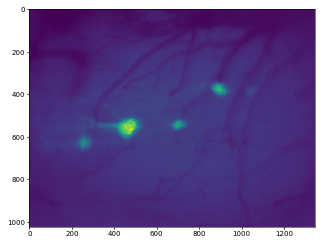

In [22]:
### just because it looks nice - 4 MOR18.2 instances in one glomerulus
print mf.base.shaped2D().shape
print bg.shape
imshow(bg)
plt.show()

## Figure S1: exemplary odor responses (filtered but not decomposed). 

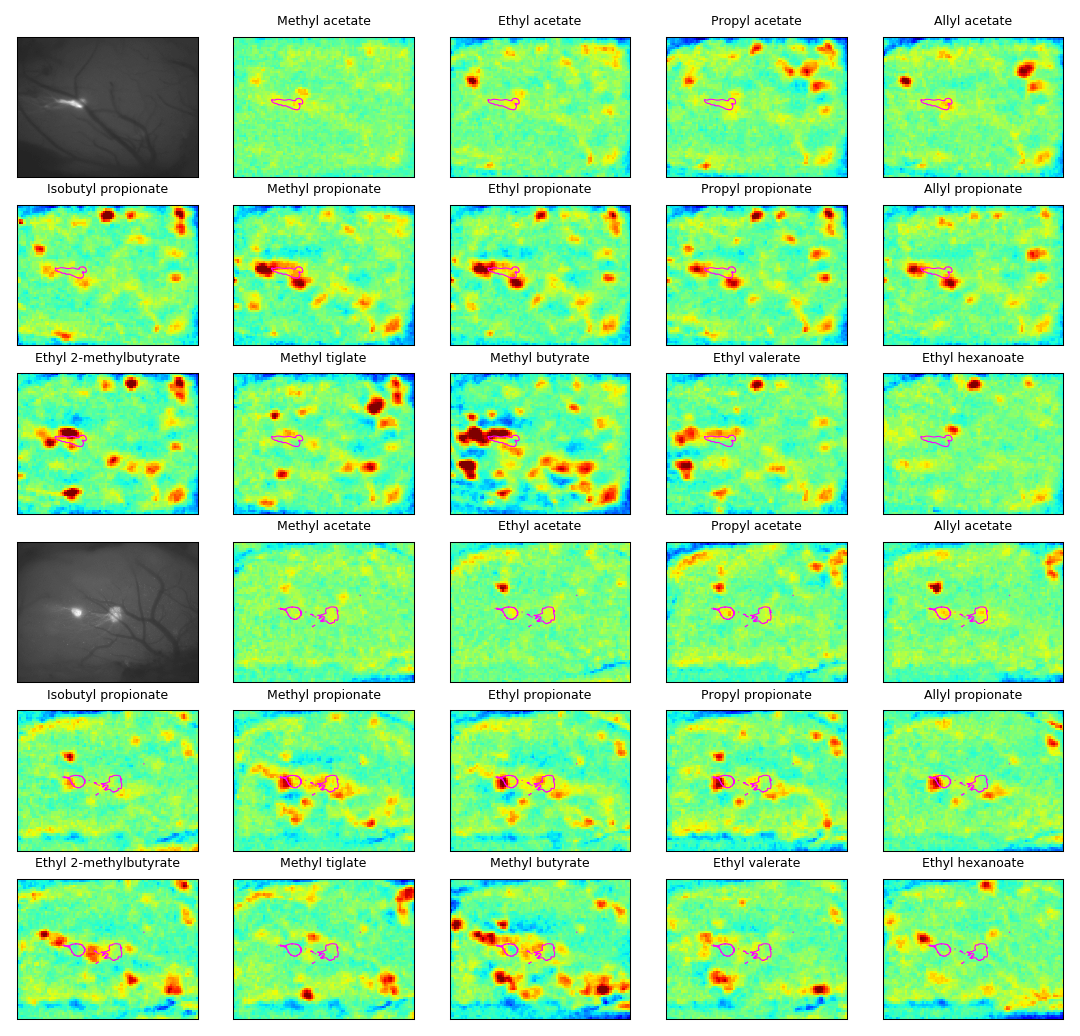

In [24]:
mycas = ['79-20-9', '141-78-6','109-60-4','591-87-7',
         '540-42-1','554-12-1','105-37-3', '106-36-5', '2408-20-0',
         '7452-79-1','6622-76-0','623-42-7', '539-82-2','123-66-0']
         #'79-09-4', '78-98-8',]
    
animals = ["120125","120107"] 
contour_ths = [0.33, 0.4]

fd = (8, 12)
fig = plt.figure(figsize=fd)
gs = gridspec.GridSpec(10,5)
gs.update(**{'left':0.05, 'right':0.95, 'top':0.97, 'bottom':0.05, 'wspace':0.01})


for animal_ind in range(2):
    filt_data_file = os.path.join(basepath, 'MOBconverted', animals[animal_ind], 'ios_meas')
    filt_data = ia.TimeSeries()
    filt_data.load(filt_data_file)

    bg_file = os.path.join(basepath, 'MOBconverted', animals[animal_ind], 'bg.png')
    bg = plt.imread(bg_file)

    mean_maps = ia.SingleSampleResponse()(filt_data)
    mean_pics = np.mean(mean_maps.trial_shaped2D(), axis=1) # work around strange bug in SingleSampleResponse
    labels = [l.split("_")[0] for l in mean_maps.label_stimuli]

    #fig.text(0.185, 0.97, '(b)', ha='right', va='bottom', fontsize=8, fontweight='bold')
    # plot image maps
    for ix, cas in enumerate(mycas): #mean_maps.label_stimuli):
        #    toplot = mean_maps.shaped2D()[labels.index(cas)]
        toplot = mean_pics[labels.index(cas)]
        ax = fig.add_subplot(gs[ix+1 + animal_ind*15])
        mymax = np.max(toplot)
        #toplot /= mymax
        #toplot[toplot<0] = 0
        #alpha = 0.75*np.ones(toplot.shape)
        #alpha[toplot<0.3] = 0
        #toplot = plt.cm.jet(toplot)
        #toplot[:,:,3] = alpha

        im_h = ax.imshow(toplot, interpolation='nearest', vmin=-1., vmax=1., extent=[0,164,0.5,128], cmap='jet')
        cont = ax.contour(bg, [contour_ths[animal_ind]], 
                          extent=[0,164,128,0.5], colors=['magenta'], linewidths=0.5)
        #cont = ax.contour(green, [0.4], extent=[0,164,0.5,128], colors=['k'])
        ax.set_title(cas2name[cas], size=6)
        ax.set_xticks([])
        ax.set_yticks([])

    #ax = fig.add_subplot(gs[0])   
    #im_h = ax.imshow(green, interpolation='none', cmap=plt.cm.bone)
    ax = fig.add_subplot(gs[0 + animal_ind*15])   
    im_h = ax.imshow(bg, interpolation='none', extent=[0,164,128,0.5], cmap=plt.cm.binary_r, vmin=-0.1)
    ax.set_xticks([])
    ax.set_yticks([])

    # add colorbar
    '''
    axbar = fig.add_axes([0.77, bottom_line1, 0.01, 0.97-bottom_line1])
    cbar = fig.colorbar(im_h, axbar)
    cbar.set_ticks([-3,0,3])
    cbar.set_label(r'$-\Delta R/R$'+ u' [\u2030]', size=global_fs, labelpad=-2)
    axbar.yaxis.set_tick_params(labelsize=global_fs, pad=2)
    '''
plt.show()

In [25]:
fig.savefig(os.path.join(savepath,'S1.png'), bbox_inches='tight', dpi=600)

ValueError: num must be 1 <= num <= 30, not 31

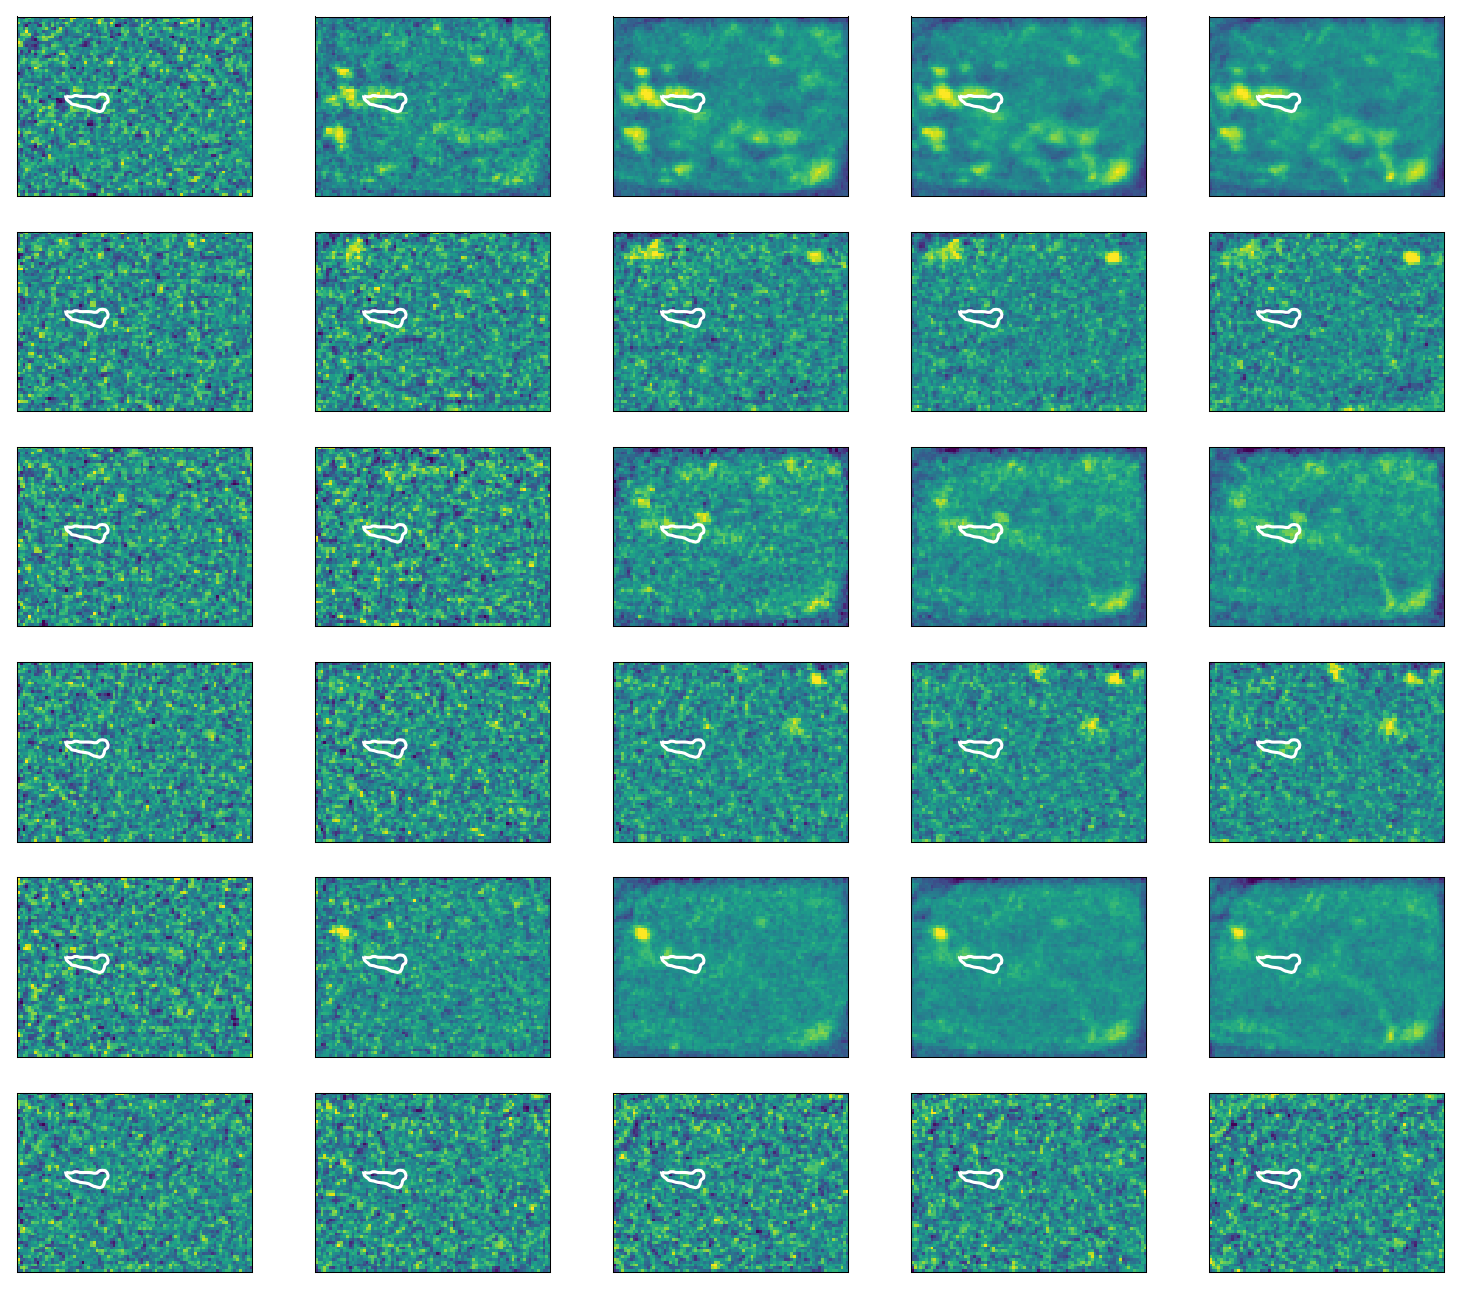

In [26]:
##########
# DELETE FROM submission
###########
from PIL import Image

mycas = ['79-20-9', '141-78-6','109-60-4','591-87-7',
         '540-42-1','554-12-1','105-37-3', '106-36-5', '2408-20-0',
         '7452-79-1','6622-76-0','623-42-7', '539-82-2','123-66-0']
         #'79-09-4', '78-98-8',]
    
animals = ['120125','120107'] 

datapath = os.path.join(basepath, 'MOBconverted')

for animal in animals:    
    bgpath = os.path.join(datapath, animal, 'bg.png')
    if os.path.exists(bgpath):
        bg = Image.open(bgpath)
        bg = bg.convert('L')
    else:
        bgpath=False
    
    fileloc = os.path.join(datapath, animal, 'ios_meas')
    ts = ia.TimeSeries()
    ts.load(fileloc)
    tsm = ia.SingleSampleResponse()(ts)
    
    labels = [l.split("_")[0] for l in tsm.label_stimuli]
    indices = np.array([labels.index(cas) for cas in mycas])
    tsm = ia.SelectTrials()(tsm, indices)
    
    if bgpath:
        bg = bg.resize(tsm.shape[::-1])
        bg = np.asarray(bg)
    
#    rows = np.ceil((len(ts.label_stimuli)+1)/5.)*2
    rows = np.ceil((len(mycas)+1)/5.)*2
    fig = plt.figure(figsize=(10, 1.5*int(rows)))
    plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.95)
    
    if bgpath:
        ax = fig.add_subplot(rows, 5, 1)
        ax.imshow(bg, origin='upper', cmap=plt.cm.bone)
        ax.set_xticks([])
        ax.set_yticks([])
        
#    for ix,cas in enumerate(mycas):   
    for oix, odormap in enumerate(ts.shaped2D()):
#        toplot = mean_maps.shaped2D()[mean_maps.label_stimuli.index(cas)]
#        ax = fig.add_subplot(gs[ix+1])
#        mymax = np.max(toplot)
#
#        im_h = ax.imshow(toplot, interpolation='nearest', vmin=-3.5, vmax=3.5)
#        cont = ax.contour(bg, [0.4], extent=[0,164,0.5,128], colors=['w'])
#        #cont = ax.contour(green, [0.4], extent=[0,164,0.5,128], colors=['k'])
#        ax.set_title(cas2name[cas], size=6)
#        ax.set_xticks([])
#        ax.set_yticks([])
        
        ax = fig.add_subplot(rows, 5, oix+1)
        amax = np.percentile(np.abs(odormap),99.85)
        ax.imshow(odormap, vmin=-amax, vmax=amax, interpolation='none', origin='upper')
        ax.contour(bg, [np.percentile(bg.flatten(), 99)], colors=['w'])#99.5)], colors=['w'])
        
        ax.set_xticks([])
        ax.set_yticks([])
#        stim_name = ts.label_stimuli[oix].split('_')
#        title = cas2name[stim_name[0]]
#        if len(stim_name)>1:
#            title = title.decode("utf8") + ' (%s)'%';'.join(stim_name[1:])
#        
#        ax.set_title(title, size=5)
#        ax.set_ylabel('id:%s, max:%.2f'%(stim_name[0],amax), size=5)
        
    fig.savefig(os.path.join(savepath, "S1_"+animal+'.png'), dpi=300)
    plt.close('all')   

In [28]:
import math
import csv
with open(os.path.join(savepath, 'MOR18-2spec_pval.csv'), 'w') as f:
    writer = csv.writer(f, dialect='excel')
    rank = 1
    for i in range(len(spec)-1,0,-1):
        cas = odors_sorted[i]
        line = [rank, 
                cas,
                cas2name[cas],
                '%.3f'%spec[i], 
                '%g'%p_val_argon[i]]
        writer.writerow(line)
        rank += 1


In [29]:
import math
for i in range(len(spec)-1,0,-1):
    print cas2name[odors_sorted[i]].decode('utf-8'), '%.3f'%spec[i], '%.2f'%(4*np.sqrt(np.abs(spec[i]/math.pi))), '%.3f'%p_val_argon[i]

Allyl acetate 1.136 2.41 0.000
Ethyl acetate 1.098 2.36 0.000
Methyl propionate 1.000 2.26 0.000
Propyl acetate 0.980 2.23 0.000
Methyl acetate 0.971 2.22 0.000
Ethyl propionate 0.896 2.14 0.000
Acetaldehyde 0.749 1.95 0.000
Allyl propionate 0.660 1.83 0.000
Isobutyl acetate 0.583 1.72 0.000
Propyl propionate 0.553 1.68 0.000
Butyl acetate 0.500 1.60 0.000
Acetic acid 0.479 1.56 1.000
Methoxyacetone 0.465 1.54 0.000
Azelaic acid 0.441 1.50 1.000
cis-3-Hexenyl butyrate 0.397 1.42 1.000
Ethyl formate 0.371 1.37 0.000
Metaldehyde 0.367 1.37 1.000
Paraldehyde 0.309 1.26 0.000
Pyruvaldehyde 0.297 1.23 0.000
Ethyl acrylate 0.292 1.22 0.000
Hexyl trans-2-butenoate 0.275 1.18 1.000
Allyl tiglate 0.268 1.17 0.000
1-Ethylhexyl tiglate 0.268 1.17 0.000
Heptyl isobutyrate 0.236 1.10 1.000
Isobutyl propionate 0.231 1.08 0.000
Isopropyl acetate 0.229 1.08 0.000
3,4-Hexanedione 0.227 1.08 1.000
Isoamyl tiglate 0.222 1.06 0.000
Propyl heptanoate 0.220 1.06 1.000
Isoamyl acetate 0.216 1.05 0.000
Butyl 